In [1]:
from imp import reload
import sys
print(sys.version)
# import rpy2
import os
import numpy as np
import pandas as pd
from scipy import stats
#import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
# Use Type 1 fonts in plots.
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = False
# Do not wrap long lines
np.set_printoptions(linewidth=np.nan)
sns.set_style("whitegrid")
import runner
import umm

3.9.0 (default, Nov 21 2020, 14:55:42) 
[Clang 12.0.0 (clang-1200.0.32.27)]


## Running UMM and CEGO over one instance

The next cell allows running CEGO and UMM over a chosen instance and with the selected parameters

In [17]:
reload(runner)
# instance_name="LOP-synthetic,seed=123456,n=20,m=200,phi=0.5"
instance_name = "pfsp/tai20_5_8.fsp"
# instance_name="pfsp/rec19.txt"
# instance_name="lop/RandB/N-p50-01"
# instance_name="lop/Spec/N-pal13"
# instance_name="lop/xLOLIB/N-be75eec_150"
# instance_name="qap/nug12.dat"
budgetGA=10**3#
seed=8
budget=400#0
m_ini=10
budgetMM=10
eval_ranks = False
r_1 = [.1]
r_2 = [.9]
res = []
for ratio_samples_learn in r_1:
  for weight_mass_learn in r_2:
    out_filename = "pickles/"+instance_name.replace("/", "__").replace(".txt", "")
    df = runner.run_once("UMM", instance_name, seed,budget = budget, m_ini = m_ini, budgetMM = budgetMM, ratio_samples_learn = ratio_samples_learn, weight_mass_learn = weight_mass_learn, out_filename = out_filename, eval_ranks=eval_ranks)
#     res.append([out_filename,ratio_samples_learn, weight_mass_learn,df.Fitness.min()])
# runner.run_once("CEGO", instance_name, seed,budget = budget, m_ini = m_ini, budgetGA = budgetGA, out_filename = out_filename)

Reading instance from pfsp/tai20_5_8.fsp
header: tai_20_a 20x5 type C instance

[[37. 59. 65. 70. 94.]
 [36. 16. 94.  3. 98.]
 [ 1. 90. 96. 43. 63.]
 [ 4.  3. 47. 14. 83.]
 [64. 76. 35. 26. 19.]
 [74. 74. 34. 83. 79.]
 [32. 22. 84. 26. 54.]
 [67. 30.  3. 65. 78.]
 [73. 89. 60. 47. 29.]
 [ 7. 61. 34. 94.  8.]
 [78. 39. 70. 75. 38.]
 [64. 15. 57. 30. 97.]
 [98. 69.  8.  1. 61.]
 [60. 57. 74. 71. 10.]
 [89.  9. 13. 46. 37.]
 [49. 13. 37. 87. 16.]
 [ 2. 71. 87. 78. 78.]
 [79.  2. 71. 76. 96.]
 [79. 34. 89. 75.  9.]
 [53. 49. 57. 55. 91.]]
UMM: eval=0	F=1564.0	best_known=None
UMM: eval=1	F=1665.0	best_known=None
UMM: eval=2	F=1605.0	best_known=None
UMM: eval=3	F=1495.0	best_known=None
UMM: eval=4	F=1576.0	best_known=None
UMM: eval=5	F=1574.0	best_known=None
UMM: eval=6	F=1587.0	best_known=None
UMM: eval=7	F=1592.0	best_known=None
UMM: eval=8	F=1672.0	best_known=None
UMM: eval=9	F=1695.0	best_known=None
UMM: eval=10	F=1622.0	best_known=None
UMM: eval=11	F=1593.0	best_known=None
UMM: eval=12	

The following piece of code plots the results of the previous experiment

instance name pfsp/tai20_5_8.fsp - time 201.94
1290.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


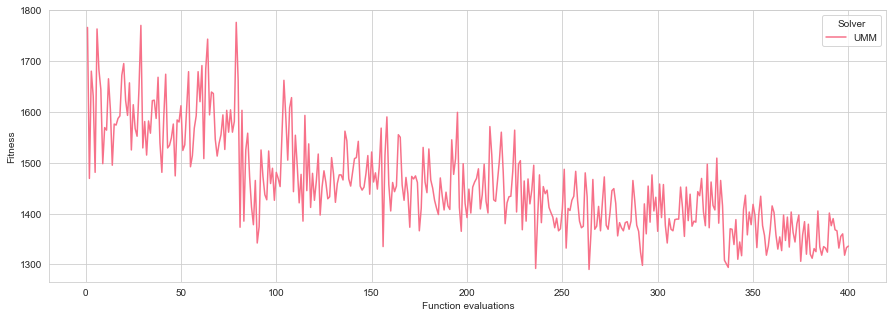

In [18]:
out_file = "pickles/"+instance_name.replace("/", "__").replace(".txt", "")
df = pd.read_pickle(out_filename+'.pkl.gz')

print("instance name", df.instance.iloc[0], "- time", round(df.run_time.iloc[0], 2))
print(df.Fitness.min())

color_variable = 'Solver'
y_variables = ['Fitness']#,'Distance','phi_sample'
palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
for y_variable in y_variables:
    plt.figure(figsize=(15,5))
    sns.lineplot(x='Function evaluations',y=y_variable,hue='Solver',data=df, palette=palette)
#     plt.savefig('img/'+instance_name.replace("/", "__").replace(".txt", "")+'order.eps')
    plt.show()

In [10]:
df

,rho,phi_estim,phi_sample,Distance,Fitness,x,m_ini,seed,budget,budgetMM,ratio_samples_learn,weight_mass_learn,eval_ranks,Function evaluations,run_time,Problem,instance,Solver
0,NaN,NaN,NaN,NaN,1766.0,"[7, 11, 6, 15, 18, 4, 12, 2, 13, 1, 16, 0, 14,...",10,8,400,10,0.1,0.9,False,1,189.665819,PFSP,pfsp/tai20_5_8.fsp,UMM
1,NaN,NaN,NaN,NaN,1469.0,"[8, 19, 0, 15, 11, 12, 1, 17, 2, 16, 10, 7, 13...",10,8,400,10,0.1,0.9,False,2,189.665819,PFSP,pfsp/tai20_5_8.fsp,UMM
2,NaN,NaN,NaN,NaN,1680.0,"[5, 14, 12, 16, 19, 3, 9, 1, 17, 4, 18, 6, 2, ...",10,8,400,10,0.1,0.9,False,3,189.665819,PFSP,pfsp/tai20_5_8.fsp,UMM
3,NaN,NaN,NaN,NaN,1631.0,"[5, 11, 4, 1, 17, 8, 3, 10, 15, 12, 13, 18, 2,...",10,8,400,10,0.1,0.9,False,4,189.665819,PFSP,pfsp/tai20_5_8.fsp,UMM
4,NaN,NaN,NaN,NaN,1481.0,"[4, 19, 13, 0, 11, 18, 1, 7, 15, 10, 3, 16, 5,...",10,8,400,10,0.1,0.9,False,5,189.665819,PFSP,pfsp/tai20_5_8.fsp,UMM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,7.275958e-12,0.444981,0.09375,NaN,1355.0,"[2, 11, 8, 0, 18, 7, 3, 12, 15, 6, 10, 4, 17, ...",10,8,400,10,0.1,0.9,False,396,189.665819,PFSP,pfsp/tai20_5_8.fsp,UMM
396,6.366463e-12,0.444173,0.09375,NaN,1360.0,"[1, 11, 7, 0, 16, 5, 3, 12, 19, 8, 10, 4, 18, ...",10,8,400,10,0.1,0.9,False,397,189.665819,PFSP,pfsp/tai20_5_8.fsp,UMM
397,5.456968e-12,0.443365,0.09375,NaN,1318.0,"[1, 11, 7, 0, 18, 5, 3, 13, 17, 8, 10, 4, 14, ...",10,8,400,10,0.1,0.9,False,398,189.665819,PFSP,pfsp/tai20_5_8.fsp,UMM
398,5.002221e-12,0.438393,0.06250,NaN,1333.0,"[1, 11, 8, 0, 18, 5, 2, 12, 17, 7, 9, 3, 16, 1...",10,8,400,10,0.1,0.9,False,399,189.665819,PFSP,pfsp/tai20_5_8.fsp,UMM


In [89]:
def synthetic_LOP(n, m, phi):
    instanceID = np.zeros((n,n))
    instanceRA = np.zeros((n,n))
    # FIXME: It should already return an array.
    s = np.asarray(mk.samplingMM(m, n, phi=phi, k=None))
    
    for i in range(n):
        for j in range(i+1,n):
            instanceID[i, j] = (s[:, i] < s[:, j]).sum() / m
            instanceID[j, i] = 1 - instanceID[i, j]
    central = np.random.permutation(n)
    s = s[:, central] #compose
    for i in range(n):
        for j in range(i+1,n):
            instanceRA[i, j] = (s[:, i] < s[:, j]).sum() / m
            instanceRA[j, i] = 1 - instanceRA[i, j]
    return instanceID, instanceRA, central
  
n=6
m,phi = 200,.9
import mallows_kendall as mk

instanceID, instanceRA, best_sol = synthetic_LOP(n, m, phi)
worst_sol = best_sol[::-1]
instanceID, instanceRA
ide = np.arange(n)
inv = np.argsort(best_sol)
s = 0
for i in range(n):
  for j in range(i):
    s += instanceRA[best_sol[i],best_sol[j]] #LT
s
np.tril(instanceID[np.ix_(ide, ide)]).sum(), np.tril(instanceRA[np.ix_(inv, inv)]).sum(), np.tril(instanceRA[np.ix_(best_sol, best_sol)]).sum(),s

(7.05, 7.05, 7.31, 7.309999999999999)

In [96]:
instanceID[np.ix_(best_sol, best_sol)] == instanceRA, instanceRA[np.ix_(inv, inv)] == instanceID

(array([[ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True]]),
 array([[ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True]]))

In [96]:
import lop as lop
reload(lop)
import random
from lop import LOP
n,m,phi,seed = 8,200,0.9,random.randint(1,10)
p= LOP.generate_synthetic(n,m,phi,seed)

identity, reverse, best-known and worst-known fitnesses 14.42 13.580000000000002 12.379999999999999 14.600000000000001


In [92]:
import lop as lop
reload(lop)
import random
from lop import LOP
n,m,phi,seed = 8,200,0.9,random.randint(1,10)
p= LOP.generate_synthetic(n,m,phi,seed)
p.instance, p.best_sol, p.fitness_nosave(p.best_sol)
ide = np.arange(n)
bes = p.best_sol
inv = np.argsort(bes)
wor = np.argsort(inv[::-1])
s = 0
for i in range(n):
  for j in range(i):
    s += p.instance[inv[i],inv[j]] #LT
print(s, bes)
# np.tril(instanceID[np.ix_(ide, ide)]).sum(), 
np.tril(p.instance[np.ix_(inv, inv)]).sum(), np.tril(p.instance[np.ix_(inv[::-1], inv[::-1])]).sum(), #esto es la identidad
# np.tril(instanceRA[np.ix_(best_sol, best_sol)]).sum(),s
p.fitness_nosave(bes), p.fitness_nosave(wor)

identity, reverse, best-known and worst-known fitnesses 14.014999999999999 13.985 12.425 14.025
12.425000000000002 [2 1 7 5 4 3 6 0]


(12.425, 15.575000000000001)

In [80]:
wor = np.argsort(inv[::-1])
s = 0
for i in range(n):
  for j in range(i):
    s += p.instance[wor[i],wor[j]] #LT
print(s, bes)


15.155 [4 0 2 7 5 6 1 3]
